# K-Means clutering technique to find PSD families within the CAMP2Ex field campain dataset

---

## Imports

In [1]:
import xarray as xr
import datatree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.transforms as mtransforms
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.special import gamma
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap

### Local Cluster

Let's spin up our `Dask` local cluster

In [22]:
cluster = LocalCluster()  
# display(cluster)

## Data

CAMP2Ex dataset is store in Analysis-Ready Cloud-Optimized (ARCO) format [Abernathey et al. 2021](https://ieeexplore.ieee.org/document/9354557) using an [Xarray-Datatree](https://xarray-datatree.readthedocs.io/en/latest/) data model that allows us to have both Learjet and P3B dataset in one `datatree`.

In [3]:
path_data = '../data/camp2ex_dtree.zarr'
dt_camp2ex = datatree.open_datatree(path_data, engine='zarr', consolidated=True)

In [4]:
display(dt_camp2ex)

DataTree('None', parent=None)
├── DataTree('Lear')
│       Dimensions:             (time: 4307, diameter: 58)
│       Coordinates:
│         * diameter            (diameter) float64 50.0 60.0 ... 3.524e+03 3.824e+03
│         * time                (time) datetime64[ns] 2019-09-07T00:50:13 ... 2019-09...
│       Data variables: (12/92)
│           Att_ka              (time) float64 ...
│           Att_ku              (time) float64 ...
│           Att_w               (time) float64 ...
│           RH                  (time) float64 ...
│           altitude            (time) float64 ...
│           att_ka_mu1          (time, diameter) float64 ...
│           ...                  ...
│           z_ku_mu3            (time) float64 ...
│           z_ku_mu_bf          (time) float64 ...
│           z_w_mu1             (time) float64 ...
│           z_w_mu2             (time) float64 ...
│           z_w_mu3             (time) float64 ...
│           z_w_mu_bf           (time) float64 ...
└── DataTree('P3B')
        Dimensions:             (time: 5146, diameter: 58)
        Coordinates:
          * diameter            (diameter) float64 50.0 60.0 ... 3.524e+03 3.824e+03
          * time                (time) datetime64[ns] 2019-08-24T22:12:20 ... 2019-10...
        Data variables: (12/92)
            Att_ka              (time) float64 ...
            Att_ku              (time) float64 ...
            Att_w               (time) float64 ...
            RH                  (time) float64 ...
            altitude            (time) float64 ...
            att_ka_mu1          (time, diameter) float64 ...
            ...                  ...
            z_ku_mu3            (time) float64 ...
            z_ku_mu_bf          (time) float64 ...
            z_w_mu1             (time) float64 ...
            z_w_mu2             (time) float64 ...
            z_w_mu3             (time) float64 ...
            z_w_mu_bf           (time) float64 ...

In [24]:
# display(dt_camp2ex['Lear'].ds)

In [23]:
# display(dt_camp2ex['P3B'].ds)

Let's select the following fields we will use during the K-means clustering analysis

In [7]:
cols = ['sigma', 'dm', 'log10_nw', 'r', 'nt', 'lwc_cum', 'dbz_t_ku', 'dbz_t_ka', 'mu']

Now we can merge both datasets into a single `Xarray.Dataset`

In [8]:
ds = xr.concat([dt_camp2ex['Lear'].ds[cols], dt_camp2ex['P3B'].ds[cols]], dim='time')

We discarded data with Liquid Water Content  $LWC <=0.01 gm^{-3}$ (Lance et at., 2010, Gupta et al 2021) and take $log_{10}$ of rainfall rate (r), total number concentration (nt) and liquid water content (lwc_cum)

In [9]:
ds = ds.where(ds.lwc_cum > 0.01, drop=True)
ds = ds
ds['logr'] = np.log10(ds.r)
ds['lognt'] = np.log10(ds.nt)
ds['loglwc'] = np.log10(ds.lwc_cum)
ds

<xarray.Dataset>
Dimensions:   (time: 8710)
Coordinates:
  * time      (time) datetime64[ns] 2019-09-07T00:50:13 ... 2019-10-05T07:14:29
Data variables:
    sigma     (time) float64 0.6386 0.6475 0.7199 ... 0.3616 0.5368 0.4025
    dm        (time) float64 1.275 1.285 1.474 1.563 ... 1.489 1.482 0.9302
    log10_nw  (time) float64 3.836 3.962 3.788 3.736 ... 3.643 3.804 3.741 4.561
    r         (time) float64 3.629 5.049 6.441 7.516 ... 6.776 7.357 6.102 4.338
    nt        (time) float64 595.6 677.2 602.4 611.1 ... 429.8 544.8 2.781e+03
    lwc_cum   (time) float64 0.222 0.3071 0.3552 0.3984 ... 0.3843 0.3261 0.3344
    dbz_t_ku  (time) float64 31.95 33.84 36.06 37.37 ... 33.97 33.9 33.95 28.67
    dbz_t_ka  (time) float64 32.28 33.27 35.18 36.04 ... 35.92 35.8 35.66 30.31
    mu        (time) float64 -0.01583 -0.0602 0.1909 ... 12.96 3.624 1.342
    logr      (time) float64 0.5598 0.7032 0.809 0.876 ... 0.8667 0.7855 0.6373
    lognt     (time) float64 2.775 2.831 2.78 2.786 ... 2.484 2.633 2.736 3.444
    loglwc    (time) float64 -0.6536 -0.5128 -0.4496 ... -0.4153 -0.4866 -0.4758

Now we converted our `Xarray.Dataset` into a `Panda.Dataframe`

In [10]:
df = ds.to_dataframe().reset_index()
display(df.head(5))

,time,sigma,dm,log10_nw,r,nt,lwc_cum,dbz_t_ku,dbz_t_ka,mu,logr,lognt,loglwc
0,2019-09-07 00:50:13,0.638638,1.274745,3.835770,3.628710,595.554870,0.222011,31.954252,32.279607,-0.015834,0.559752,2.774922,-0.653626
1,2019-09-07 00:50:14,0.647497,1.285212,3.962426,5.048991,677.244280,0.307068,33.836180,33.265364,-0.060199,0.703205,2.830745,-0.512765
2,2019-09-07 00:50:15,0.719944,1.473846,3.787725,6.441170,602.352457,0.355175,36.060344,35.180436,0.190898,0.808965,2.779851,-0.449557
3,2019-09-07 00:50:16,0.755878,1.562636,3.735953,7.516483,611.128850,0.398377,37.370368,36.037833,0.273775,0.876015,2.786133,-0.399706
4,2019-09-07 00:50:17,0.268457,1.070191,4.282757,4.585315,627.189980,0.308683,28.851578,30.202350,11.891776,0.661369,2.797399,-0.510487


## K-means

To apply the cluster analysis, we standardized our input features by removing the mean and scaling to unit variance using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from the `Sklearn` Python package

In [11]:
scaler = StandardScaler()
df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

### K-means clustering benchmarking

As a supervised machine learning technique, K-means clustering requires the number of the cluster to be defined beforehand. To determine the optimal number of clusters (k) for the PSDs, we executed the algorithm for k values ranging from 2 to 15. Using the within-cluster sum of squares (WCSS), also known as the elbow method, Davies-Bouldin index (Davies & Bouldin, 1979), and Silhouette score (Rousseeuw, 1987)

In [12]:
def get_kmeans_score(df, center):
    '''
    returns the elbow inertial index, the Davies Bouldin and Silhouette score
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        elbow inertial index, the Davies Bouldin and Silhouette score
    '''
    kmeans = KMeans(n_clusters=center, random_state=10)
    model = kmeans.fit(df)
    model2 = kmeans.fit_predict(df)
    cluster_labels = model.labels_
    
    dav = davies_bouldin_score(df, model2)
    sil = silhouette_score(df, cluster_labels)
    elbow = model.inertia_
    return dav, sil, elbow

We defined some list to store results of each cluster results for every score. Then we test each number of cluster. 

In [13]:
dav = []
sil = []
elbow = []

for k in range(2,15):
    _dav, _sil, _el = get_kmeans_score(df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]], k)
    dav.append(_dav)
    sil.append(_sil)
    elbow.append(_el)

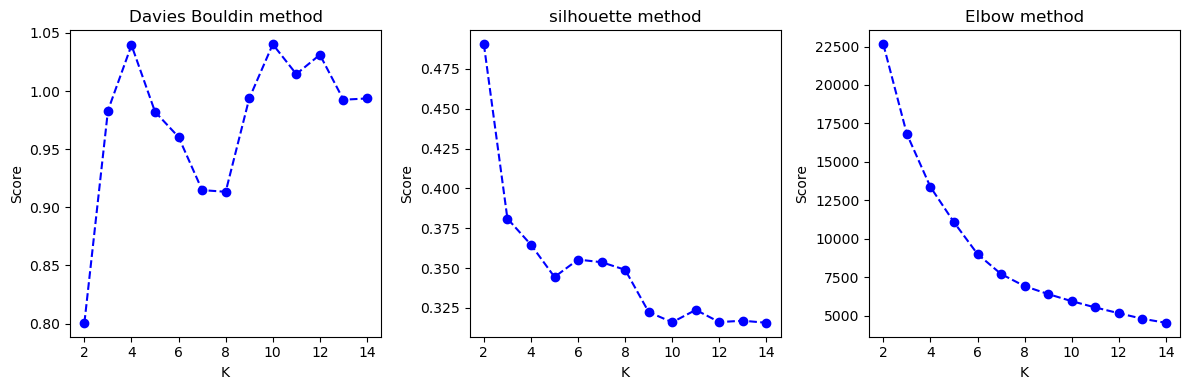

In [14]:
# Score result for different number of clusters.
centers = range(2,15)
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
ax.plot(centers, dav, linestyle='--', marker='o', color='b');
ax.set_xlabel('K');
ax.set_ylabel('Score');
ax.set_title('Davies Bouldin method');

ax1.plot(centers, sil, linestyle='--', marker='o', color='b');
ax1.set_xlabel('K');
ax1.set_ylabel('Score');
ax1.set_title('silhouette method');

ax2.plot(centers, elbow, linestyle='--', marker='o', color='b');
ax2.set_xlabel('K');
ax2.set_ylabel('Score');
ax2.set_title('Elbow method');
fig.tight_layout()

Based on this calculations, we deduced that k=6 the most suitable number of clusters representing the data.

### K-means clustering with 6 PSD families


In [15]:
n_c = 6
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=n_c, random_state=10)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=10)

In [16]:
df['kmeans_6'] = kmeans.labels_ + 1

In [17]:
df['kmeans'] = df['kmeans_6'].replace([1, 2, 3, 4, 5, 6], [5,3,4,1,2,6])
df['dfr'] = df['dbz_t_ku'] - df['dbz_t_ka']
df.shape

(8710, 22)

In [18]:
my_cmap6 = ListedColormap(sns.color_palette('deep', n_c))
colors6 = my_cmap6(np.linspace(0,1,n_c))
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

In [19]:
def norm_gamma(d, nw, mu, dm):
    """
    Functions that computes the normalized-gamma size distritubion ()
    Param d: diameter in mm
    Param nw: Normalized intercep parameter
    Param mu: Shape parameter
    Param dm: Mass-weighted mean diameter
    """
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

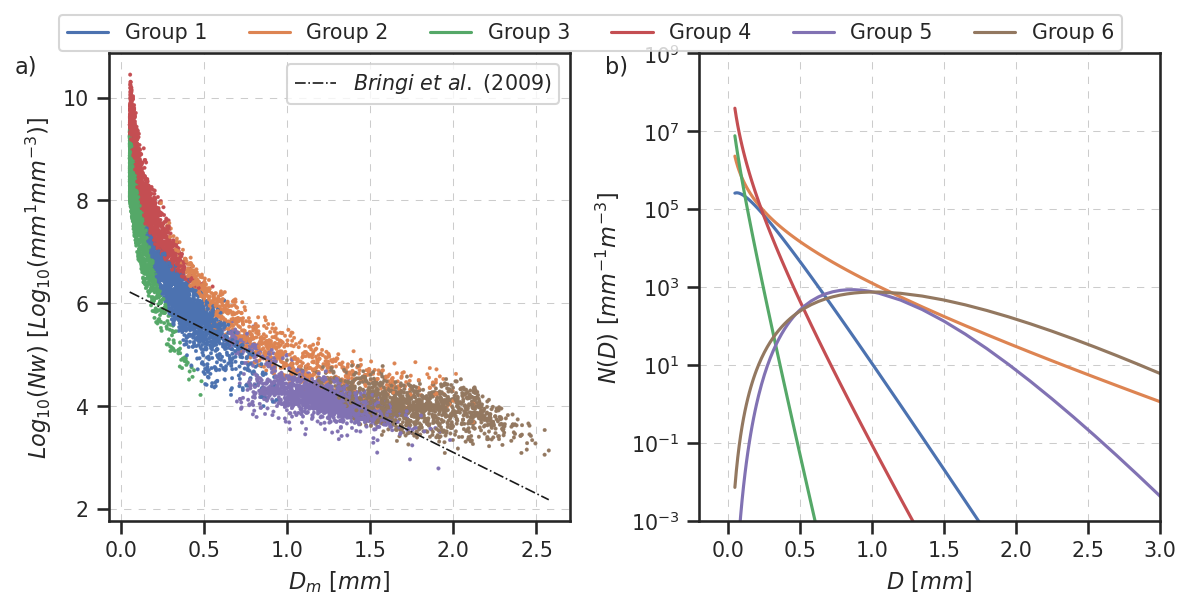

In [20]:
fig, axs = plt.subplot_mosaic([['a)', 'b)']], figsize=(8,4))

ax = axs['a)']
ax = sns.scatterplot(data=df, x=df['dm'], y=df['log10_nw'], hue=df['kmeans'], s=3, ax=ax, 
                          palette=sns.color_palette('deep', 6), legend=False, edgecolor=None)

ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

dms = np.linspace(df['dm'].min(), df['dm'].max(), 100)
s_c = -1.6 * dms + 6.3
ax.plot(dms, s_c, c='k', ls='-.', lw=0.8, label=r"$Bringi \ et \ al. \ (2009)$")
# ax.hlines(y=3.85, xmin=dms.min(), xmax=dms.max(), colors='k', linestyles='--', lw=0.8, label=r"$Thompson \ et \  al. \ (2015)$")
ax.legend()


ax1 = axs['b)']
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = dt_camp2ex['Lear'].ds.diameter/1000
ax1.grid('both')
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$")
ax1.set_xlabel("$D\ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.2, 3)

for i in range(1, n_c + 1):
    df_sub = df[df['kmeans'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i-1], label=f"Group {i}")


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]


fig.legend(lines[1:], labels[1:], loc='upper center', ncol=6, bbox_to_anchor=[0.5, 1.025])
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-45/72, -1/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
fig.tight_layout()

In [21]:
df.to_parquet('../data/df_cluster.parquet')